In [1]:
import cv2
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision 
from torchvision import transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt 

In [2]:
train_path = "/kaggle/input/cv-q3-data/train.mp4"
train_y_path = "/kaggle/input/cv-q3-data/train.txt"
test_path = "/kaggle/input/cv-q3-data/test.mp4"
test_y_path = "/kaggle/input/cv-q3-data/test.txt"

In [3]:
def select_frame(video, frame_number):
    # Set the video to the desired frame
    video.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = video.read() 
    #ret: a boolean value indicating whether the frame was successfully read, frame=a numpy array
    return frame

In [4]:
def read_labels(labels_path):
    # Open the file
    with open(labels_path, 'r') as file:
        # Read the contents of the file
        contents = file.read()

    # Split the contents by newline to get a list of strings
    lines = contents.strip().split('\n')

    # Convert each string to a number and append it to a list
    numbers = [float(line) for line in lines]
    return numbers

In [5]:
class frames_dataset(Dataset):
    def  __init__(self, video, labels):
        super().__init__()
        self.vid = video
        self.labels = labels
        
        
    def __len__(self):
        return  int(self.vid.get(cv2.CAP_PROP_FRAME_COUNT)) - 1
    
    
    def __getitem__(self,idx):
        frame1 = (select_frame(self.vid, idx))
        frame2 = (select_frame(self.vid, idx + 1))
        
        # Convert the frames to grayscale
        gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
        gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

        # Calculate the optical flow using the Farneback algorithm
        flow = cv2.calcOpticalFlowFarneback(gray1, gray2, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        flow = torch.tensor(flow).permute((2,0,1))
        
        return frame1, frame2, flow, self.labels[idx]

In [6]:
class OpticalFlowSpeedEstimator(nn.Module):
    def __init__(self, input_channels):
        super(OpticalFlowSpeedEstimator, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(1228800, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 1)

    def forward(self, optical_flow):
        x = self.conv1(optical_flow)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)
        #print(x.shape)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

In [23]:
video_train = cv2.VideoCapture(train_path)
train_y = read_labels(train_y_path)
video_test = cv2.VideoCapture(test_path)
test_y = read_labels(test_y_path)

batch_size=32
lr = 1e-7
num_epochs=10

In [24]:
train_dataset=frames_dataset(video_train, train_y)
test_dataset=frames_dataset(video_test, test_y)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [25]:
model = OpticalFlowSpeedEstimator(2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.L1Loss()

Epoch [1/10], Step [5/20], Loss: 12.5626
Epoch [1/10], Step [10/20], Loss: 11.9983
Epoch [1/10], Step [15/20], Loss: 12.3490
Epoch [1/10], Step [20/20], Loss: 12.3527
Epoch [2/10], Step [5/20], Loss: 11.5666
Epoch [2/10], Step [10/20], Loss: 12.2392
Epoch [2/10], Step [15/20], Loss: 11.3785
Epoch [2/10], Step [20/20], Loss: 11.7200
Epoch [3/10], Step [5/20], Loss: 9.3704
Epoch [3/10], Step [10/20], Loss: 12.3303
Epoch [3/10], Step [15/20], Loss: 7.9924
Epoch [3/10], Step [20/20], Loss: 10.9472
Epoch [4/10], Step [5/20], Loss: 11.7690
Epoch [4/10], Step [10/20], Loss: 11.4706
Epoch [4/10], Step [15/20], Loss: 11.2692
Epoch [4/10], Step [20/20], Loss: 8.8951
Epoch [5/10], Step [5/20], Loss: 10.5644
Epoch [5/10], Step [10/20], Loss: 11.5905
Epoch [5/10], Step [15/20], Loss: 13.0967
Epoch [5/10], Step [20/20], Loss: 11.4023
Epoch [6/10], Step [5/20], Loss: 10.5833
Epoch [6/10], Step [10/20], Loss: 10.7698
Epoch [6/10], Step [15/20], Loss: 12.6855
Epoch [6/10], Step [20/20], Loss: 10.4452
E

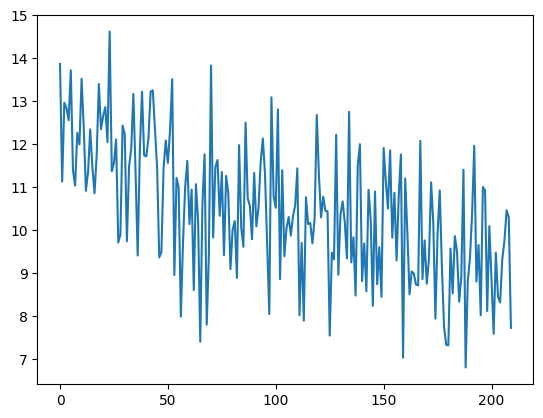

In [26]:
losses=[]
# Training loop
#total_steps = len(train_loader)
total_steps=20
for epoch in range(num_epochs):
    model.train()
    for i, (frame1, frame2, hsv_flows, labels) in enumerate(train_loader):
        hsv_flows = hsv_flows.to(torch.float32).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(hsv_flows)
        loss = criterion(outputs.squeeze(0), labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.to("cpu").item())

        if (i + 1) % 5 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{total_steps}], Loss: {loss.item():.4f}')
        torch.cuda.empty_cache()
        if(i>=total_steps):
            break
plt.plot(losses)

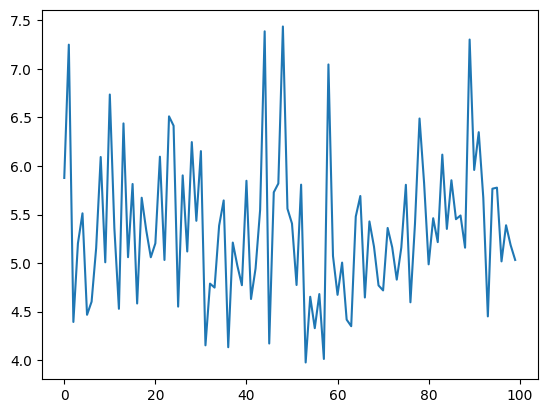

In [27]:
# Testing phase
model.eval()
j = 0
with torch.no_grad():
    test_losses=[]
    for i, (frame1, frame2, hsv_flows, labels) in enumerate(test_loader):
        hsv_flows = hsv_flows.to(device).to(torch.float32)
        labels = labels.to(device)
        
        outputs = model(hsv_flows)
        loss = criterion(outputs, labels) 
        test_losses.append(loss.to("cpu").item())
            # del x, y
        torch.cuda.empty_cache()
        j += 1
        if(j>=100):
            break

plt.plot(test_losses)

In [28]:
# Save the model's state_dict
torch.save(model.state_dict(), 'model.pth')

In [29]:
def flow_to_hsv(flow):
        flow = flow.numpy()
        # Convert the flow vectors to polar coordinates
        mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])

        # Create the HSV image
        hsv_flow = np.zeros_like(frame1)
        hsv_flow[..., 1] = 255
        hsv_flow[..., 0] = ang * 180 / np.pi / 2
        hsv_flow[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)

        hsv_flow = torch.tensor(hsv_flow)
        return hsv_flow

In [ ]:
test_loader2 = DataLoader(test_dataset, batch_size, shuffle=False)

annotated_frames = []
#  Iterate through the dataset
for i, (frames1, frames2, flows, labels) in enumerate(test_loader2):
    
    flows = flows.to(device).to(torch.float32)
    with torch.no_grad():
        speeds = model(flows)
        
    for i in range(batch_size):
        frame1 = frames1[i]
        frame2 = frames2[i]
        speed = speeds[i].item()

        annotated_frame = cv2.putText(
            cv2.cvtColor(frame1[:3].permute(1, 2, 0).byte().cpu().numpy(), cv2.COLOR_RGB2BGR),
            f"Predicted speed: {speed:.2f} m/s",
            org=(10, 50),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1,
            color=(0, 255, 0),
            thickness=2
        )

        # Append the annotated frame to the list
        annotated_frames.append(annotated_frame)

# Create the output video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output.mp4', fourcc, 30.0, (frame1.size(-1), frame1.size(-2)))

for frame in annotated_frames:
    out.write(frame)

out.release()

In [ ]:
# Create a VideoWriter object
out = cv2.VideoWriter('output_video2.avi', cv2.VideoWriter_fourcc(*'XVID'), 20.0, (640, 480))

#  Iterate through the dataset
for i, (frames1, frames2, flows, labels) in enumerate(test_loader2):    
    flows = flows.to(device).to(torch.float32)
    with torch.no_grad():
        speeds = model(flows)
        
    for i in range(batch_size):
        frame1 = frames1[i]
        frame2 = frames2[i]
        flow = flows[i]
        speed = speeds[i].item()

           
        hsv_flow = flow_to_hsv(flow)
        hsv_flow = hsv_flow.permute((1, 2, 0)).numpy()
        flow_vis = cv2.cvtColor(hsv_flow, cv2.COLOR_HSV2BGR)
        
        # Combine original frame and optical flow visualization
    combined_frame = np.hstack((frame1, flow_vis))

    # Add predicted speed text
    cv2.putText(combined_frame, f'Speed: {speed:.2f}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Write the frame to the video
    out.write(combined_frame)

# Release the video writer
out.release()